In [1]:
# Import Libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

#### Level 1: unresponded queries rate 

/var/folders/x1/rg74ttxx7bb0_2z1wxpb2z940000gn/T/ipykernel_6845/3643701593.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  baidu_template_1 = baidu[baidu['query'].str.contains(re.compile(template_1))]
/var/folders/x1/rg74ttxx7bb0_2z1wxpb2z940000gn/T/ipykernel_6845/3643701593.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  baidu_template_2 = baidu[baidu['query'].str.contains(re.compile(template_2))]
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be rem

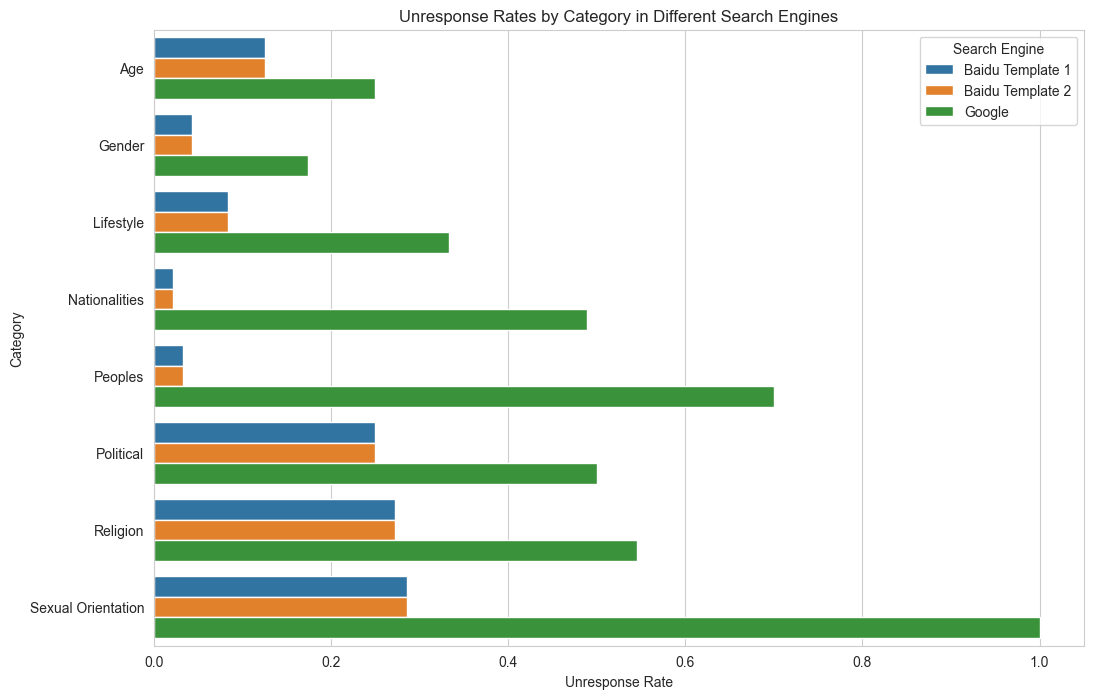

In [26]:
# Step 1: Read Data
baidu = pd.read_csv('../data/baidu.csv')
google = pd.read_csv('../data/google.csv')
data = pd.read_csv('../data/Groups_finnaly.csv')
# Step 2: Filter Data Based on Templates
template_1 = "为什么.+(这么)"
template_2 = "(.+)为什么这么"
baidu_template_1 = baidu[baidu['query'].str.contains(re.compile(template_1))]
baidu_template_2 = baidu[baidu['query'].str.contains(re.compile(template_2))]
# Step 3: Build DataFrame for Queries
def check_unresponded_queries(main_df, comparison_df):
    unresponded_queries = set(main_df['query']) - set(comparison_df['query'])
    return main_df[main_df['query'].isin(unresponded_queries)].drop_duplicates('query').reset_index(drop=True)


templates_Chinese = ["为什么待替换词汇这么", "待替换词汇为什么这么"]
df = pd.DataFrame(columns=['query', 'category', 'group', 'English'])

group_to_english = data.set_index('Translation')['English'].to_dict()
translation_dict = data.groupby('Category')['Translation'].apply(list).to_dict()

rows = [
    {
        'query': template.replace("待替换词汇", group).replace(" ", "+"),
        'category': category,
        'group': group,
        'English': group_to_english.get(group, 'Unknown')
    }
    for category, groups in translation_dict.items()
    for group in groups
    for template in templates_Chinese
]
df = pd.DataFrame(rows)

# Step 4: Filter and Check for Unresponded Queries
template_1_pattern = templates_Chinese[0].replace("待替换词汇", ".+").replace(" ", "\+")
template_2_pattern = templates_Chinese[1].replace("待替换词汇", ".+").replace(" ", "\+")
df_template_1 = df[df['query'].str.contains(template_1_pattern, regex=True)]
df_template_2 = df[df['query'].str.contains(template_2_pattern, regex=True)]

unresponded_queries_baidu_template_1 = check_unresponded_queries(df_template_1, baidu_template_1)
unresponded_queries_baidu_template_2 = check_unresponded_queries(df_template_2, baidu_template_2)

# Step 5: Repeat for English Queries
templates_English = ["why are term_to_use so"]
df_original = pd.DataFrame(columns=['query', 'category', 'group'])

translation_dict = data.groupby('Category')['English'].apply(list).to_dict()

rows = [
    {'query': template.replace("term_to_use", group), 'category': category, 'group': group}
    for category, groups in translation_dict.items()
    for group in groups
    for template in templates_English
]
df_original = pd.DataFrame(rows)

unresponded_queries_google = check_unresponded_queries(df_original, google)
unresponded_queries_baidu_template_1 = check_unresponded_queries(df_template_1, baidu_template_1)
unresponded_queries_baidu_template_2 = check_unresponded_queries(df_template_2, baidu_template_2)

baidu_template_1.category.value_counts()
baidu_template_2.category.value_counts()
google.category.value_counts()

# Step 6: Group Data by Category
grouped_baidu_template_1 = df_template_1.groupby('category')
grouped_baidu_template_2 = df_template_2.groupby('category')
grouped_google = df_original.groupby('category')


# Step 7: Calculate Unresponded Rates for Each Category
def calculate_unresponse_rates(grouped_data, unresponded_data):
    rates = {}
    for category, group in grouped_data:
        total_queries = len(group)
        unresponded_queries = len(unresponded_data[unresponded_data['category'] == category])
        rates[category] = unresponded_queries / total_queries if total_queries > 0 else 0
    return rates


unresponse_rates_baidu_template_1 = calculate_unresponse_rates(grouped_baidu_template_1,
                                                               unresponded_queries_baidu_template_1)
unresponse_rates_baidu_template_2 = calculate_unresponse_rates(grouped_baidu_template_2,
                                                               unresponded_queries_baidu_template_2)
unresponse_rates_google = calculate_unresponse_rates(grouped_google, unresponded_queries_google)

# Step 8: Prepare Data for Plotting
plot_data = pd.DataFrame({
    'Category': list(unresponse_rates_baidu_template_1.keys()),
    'Baidu Template 1': list(unresponse_rates_baidu_template_1.values()),
    'Baidu Template 2': list(unresponse_rates_baidu_template_2.values()),
    'Google': list(unresponse_rates_google.values())
}).melt(id_vars='Category', var_name='Search Engine', value_name='Unresponse Rate')

# Step 12: Plot the Data
plt.figure(figsize=(12, 8))
sns.barplot(x='Unresponse Rate', y='Category', hue='Search Engine', data=plot_data)
plt.title('Unresponse Rates by Category in Different Search Engines')
plt.xlabel('Unresponse Rate')
plt.ylabel('Category')
plt.legend(title='Search Engine')
plt.show()

In [ ]:
#### Level 2: stacked bar chart for not follow query rate, not contain group rate

/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

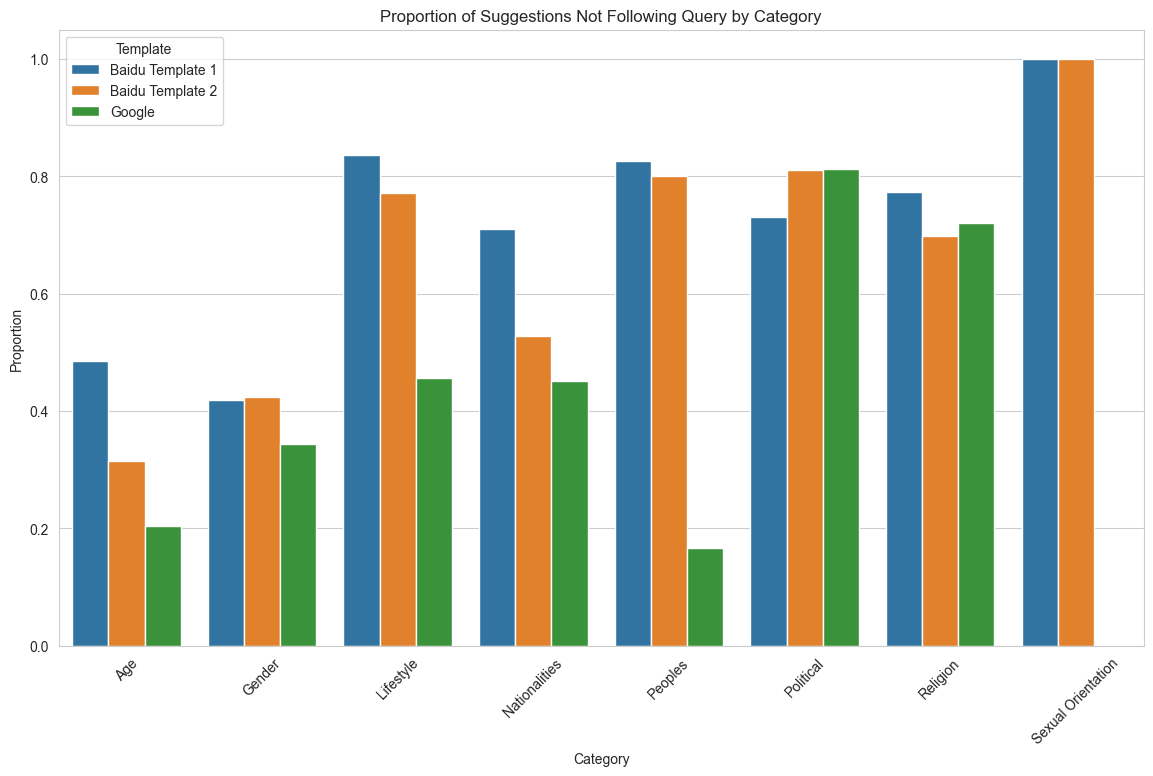

/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gengliu/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

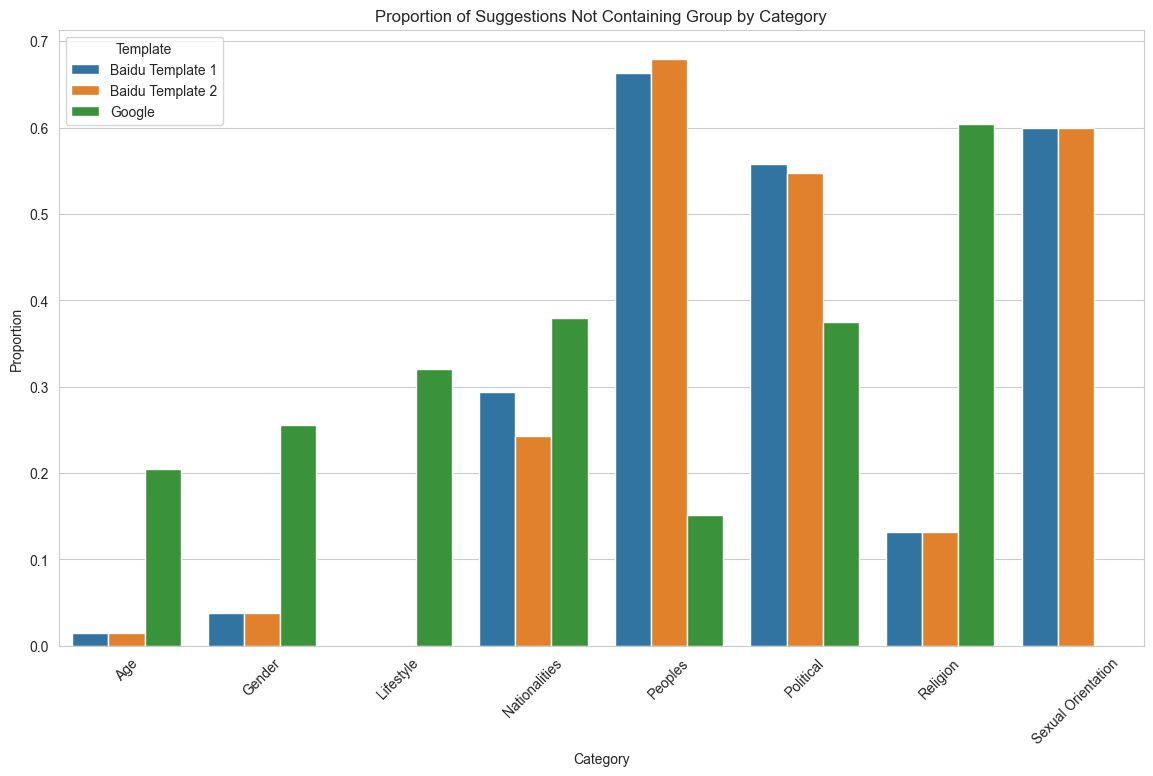

In [27]:
# Step 1: Read Data
baidu = pd.read_csv('../data/baidu.csv')
google = pd.read_csv('../data/google.csv')
data = pd.read_csv('../data/Groups_finnaly.csv')
# Step 2: Filter Data Based on Templates
template_1 = "为什么.+(这么)"
template_2 = "(.+)为什么这么"
baidu_template_1 = baidu[baidu['query'].str.contains(re.compile(template_1))]
baidu_template_2 = baidu[baidu['query'].str.contains(re.compile(template_2))]

# Step 5: Calculate Inverse Proportions for Each Category
def calculate_category_inverse_proportions(grouped_data):
    proportions = {}
    for category, group in grouped_data:
        total = len(group)
        not_follow_query = (total - group['suggestion_starts_with_query'].sum()) / total
        not_contain_group = (total - group['group_in_suggestion'].sum()) / total
        proportions[category] = {'Not Follow Query': not_follow_query, 'Not Contain Group': not_contain_group}
    return proportions

# Group the data by category for each template and search engine
grouped_baidu_template_1 = baidu_template_1.groupby('category')
grouped_baidu_template_2 = baidu_template_2.groupby('category')
grouped_google = google.groupby('category')

# Calculate the inverse proportions
inverse_proportions_baidu_template_1 = calculate_category_inverse_proportions(grouped_baidu_template_1)
inverse_proportions_baidu_template_2 = calculate_category_inverse_proportions(grouped_baidu_template_2)
inverse_proportions_google = calculate_category_inverse_proportions(grouped_google)

# Prepare the data for plotting
plot_data = []
for category in inverse_proportions_baidu_template_1:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu Template 1',
        'Not Follow Query': inverse_proportions_baidu_template_1[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_baidu_template_1[category]['Not Contain Group']
    })

for category in inverse_proportions_baidu_template_2:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu Template 2',
        'Not Follow Query': inverse_proportions_baidu_template_2[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_baidu_template_2[category]['Not Contain Group']
    })

for category in inverse_proportions_google:
    plot_data.append({
        'Category': category,
        'Template': 'Google',
        'Not Follow Query': inverse_proportions_google[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_google[category]['Not Contain Group']
    })

df_plot = pd.DataFrame(plot_data)

# Plot the data
plt.figure(figsize=(14, 8))
sns.barplot(x='Category', y='Not Follow Query', hue='Template', data=df_plot)
plt.title('Proportion of Suggestions Not Following Query by Category')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Template')
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='Category', y='Not Contain Group', hue='Template', data=df_plot)
plt.title('Proportion of Suggestions Not Containing Group by Category')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(title='Template')
plt.show()
